# Imports

In [36]:
import argparse
import keras
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Conv1D, MaxPooling1D
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model
from keras.callbacks import TensorBoard
import numpy as np
import os
from time import time
from IPython.display import Image

# Parameters

In [37]:
data_path = "/Users/Jeff/Google Drive/Drive/Work/SAP/test_data/image_datasets/oilwater/"
validation_split = 0.2
input_shape = 299
batch_size = 32
color_scale = 3
epochs = 3

# Process Input Data

In [48]:
train_gen = ImageDataGenerator(
    rescale=1./255,         # this is for rgb colors?
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=validation_split,
)

train_iterator = train_gen.flow_from_directory(
    data_path,
    target_size=(input_shape, input_shape),
    batch_size=batch_size,
    shuffle=True,
    subset='training',  # other option is 'validation'
)
validation_iterator = train_gen.flow_from_directory(
    data_path,
    target_size=(input_shape, input_shape),
    batch_size=batch_size,
    shuffle=True,
    subset='validation'
)
predict_iterator = train_gen.flow_from_directory(
    data_path,
    target_size=(input_shape, input_shape),
    batch_size=batch_size,
    shuffle=False,
    subset='validation'
)
print("[INFO] Inferred classes: " + str(train_iterator.class_indices))
print("[INFO] Number of classes: " + str(len(train_iterator.class_indices)))

Found 338 images belonging to 2 classes.
Found 84 images belonging to 2 classes.
Found 84 images belonging to 2 classes.
[INFO] Inferred classes: {'oil': 0, 'water': 1}
[INFO] Number of classes: 2


# Define and Compile Model Structure

In [39]:
model = Sequential()
model.add(Conv2D(
    32, kernel_size=(3, 3), strides=(1, 1),
    activation='relu',
    input_shape=(input_shape, input_shape, color_scale)
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_iterator.class_indices), activation='softmax'))

model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.RMSprop(),
    metrics=['accuracy']
)

# Train Model

In [41]:
model.fit_generator(
    train_iterator,
    validation_data=validation_iterator,
    epochs=epochs,
    verbose=1
)

Epoch 1/3
11/11 [==============================] - 29s 3s/step - loss: 0.6101 - acc: 0.7650 - val_loss: 0.4283 - val_acc: 0.9167
Epoch 2/3
11/11 [==============================] - 28s 3s/step - loss: 0.6740 - acc: 0.7549 - val_loss: 0.4280 - val_acc: 0.8810
Epoch 3/3
11/11 [==============================] - 29s 3s/step - loss: 0.5105 - acc: 0.8017 - val_loss: 0.4381 - val_acc: 0.8929


# Evaluate Model

In [47]:
eval_result = model.evaluate_generator(
    predict_iterator
)
for i in range(len(model.metrics_names)):
    print("[INFO] " + model.metrics_names[i] +
          ":% .2f %%" % (eval_result[i]*100))
    
predict_result = model.predict_generator(predict_iterator)
predict_result_binary = np.argmax(predict_result, axis=-1)
res_split = np.split(predict_result_binary, 2)
print("\nOil...")
print(res_split[0])
print("Water...")
print(res_split[1])

[INFO] loss: 42.60 %
[INFO] acc: 89.29 %

Oil...
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Water...
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 1]


# Predict Using Model

[oil, water]
[0.7405778  0.25942212]


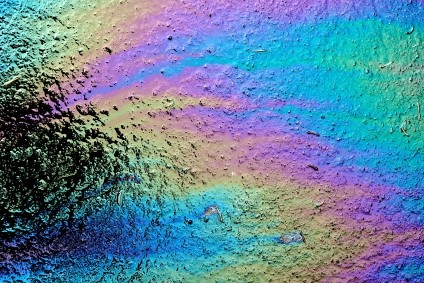

In [49]:
image_path = "/Users/Jeff/Downloads/oil_test002.jpg"
x = load_img(image_path, target_size=(299, 299))
x = img_to_array(x)
x = x/255.
x = np.expand_dims(x, axis=0)
res = model.predict(x)
print("[oil, water]")
print(res[0])
Image(image_path, width=300, height=300)